In [1]:
import pickle
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load data and prepare test set
match_df = pickle.load(open("data/prepped_match_df.pck", "rb"))

# Load encoder
enc = pickle.load(open("encoder.pck", "rb"))

# Encode target variable
match_df["resultClass"] = enc.transform(match_df["resultClass"])

# Split data (same as in model_building.ipynb)
X_train, X_test, y_train, y_test = train_test_split(match_df.drop("resultClass", axis=1), match_df["resultClass"], test_size=0.2, shuffle=False)

# Kicktipp scorer function from model_building.ipynb
def score(y_true, y_pred, **kwargs):
    # Convert to int64 to handle AutoGluon's float32 predictions
    y_true = y_true.astype('int64') if hasattr(y_true, 'astype') else np.array(y_true, dtype='int64')
    y_pred = y_pred.astype('int64') if hasattr(y_pred, 'astype') else np.array(y_pred, dtype='int64')
    
    y_true = [x.split(":") for x in enc.inverse_transform(y_true)]
    y_pred = [x.split(":") for x in enc.inverse_transform(y_pred)]
    score_value = 0
    for true, pred in zip(y_true, y_pred):
        if true[0] == pred[0] and true[1] == pred[1]:
            score_value += 5
        elif (int(true[0]) - int(true[1])) == (int(pred[0]) - int(pred[1])):
            score_value += 3
        elif ((true[0] > true[1]) and (pred[0] > pred[1])) or ((true[0] < true[1]) and (pred[0] < pred[1])):
            score_value += 1
    return round(score_value / (len(y_true)/306))

print(f"Data loaded: {len(match_df)} matches")
print(f"Test set size: {len(X_test)} matches")
print(f"Available seasons in test data: {sorted(X_test['season'].unique())}")


Data loaded: 4832 matches
Test set size: 967 matches
Available seasons in test data: [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


In [2]:
# Load all classifiers and get valid seasons (avoid duplicate loading)
classifier_files = glob.glob("classifier_*.pck")
classifier_files.sort()

# Load all classifiers once
classifiers = {}
for classifier_file in classifier_files:
    classifiers[classifier_file] = pickle.load(open(classifier_file, "rb"))

# Get valid seasons (306 games) once
seasons = sorted(X_test['season'].unique())
valid_seasons = []
for season in seasons:
    season_mask = X_test['season'] == season
    if len(X_test[season_mask]) == 306:
        valid_seasons.append(season)

# Calculate overall performance for all models
print("Model Comparison on Test Data:")
print("=" * 50)

overall_results = []
for classifier_file, classifier in classifiers.items():
    predictions = classifier.predict(X_test)
    kicktipp_score = score(y_test, predictions)
    overall_results.append({
        'Model': classifier_file,
        'Kicktipp Score': kicktipp_score
    })
    print(f"{classifier_file:<35} | {kicktipp_score:>3} points")

# Create comparison DataFrame
comparison_df = pd.DataFrame(overall_results)
comparison_df = comparison_df.sort_values('Kicktipp Score', ascending=False)

print("\nRanking:")
print("-" * 50)
for i, row in comparison_df.iterrows():
    print(f"{comparison_df.index.get_loc(i) + 1}. {row['Model']:<30} | {row['Kicktipp Score']:>3} points")

best_model = comparison_df.iloc[0]['Model']
best_score = comparison_df.iloc[0]['Kicktipp Score']
print(f"\nBest Model: {best_model} with {best_score} points")

# Calculate seasonal performance matrix (reuse loaded classifiers)
print(f"\n\nSeason-wise Performance Analysis ({len(valid_seasons)} seasons with 306 games):")
print("=" * 60)

seasonal_performance = {}
for season in valid_seasons:
    print(f"\nSeason {season}:")
    print("-" * 15)
    
    season_mask = X_test['season'] == season
    season_X = X_test[season_mask]
    season_y_true = y_test[season_mask]
    
    seasonal_performance[season] = {}
    for i, (classifier_file, classifier) in enumerate(classifiers.items(), 1):
        season_predictions = classifier.predict(season_X)
        season_score = score(season_y_true, season_predictions)
        seasonal_performance[season][classifier_file] = season_score
        print(f"Clf_{i}: {season_score} Points ({classifier_file})")


Model Comparison on Test Data:
classifier_20250927_174216.pck      | 336 points
classifier_20250928_123113.pck      | 326 points
classifier_20250928_125632.pck      | 326 points
classifier_20250928_130447.pck      | 326 points
classifier_20250928_130858.pck      | 326 points

Ranking:
--------------------------------------------------
1. classifier_20250927_174216.pck | 336 points
2. classifier_20250928_123113.pck | 326 points
3. classifier_20250928_125632.pck | 326 points
4. classifier_20250928_130447.pck | 326 points
5. classifier_20250928_130858.pck | 326 points

Best Model: classifier_20250927_174216.pck with 336 points


Season-wise Performance Analysis (3 seasons with 306 games):

Season 2022:
---------------
Clf_1: 323 Points (classifier_20250927_174216.pck)
Clf_2: 301 Points (classifier_20250928_123113.pck)
Clf_3: 301 Points (classifier_20250928_125632.pck)
Clf_4: 301 Points (classifier_20250928_130447.pck)
Clf_5: 301 Points (classifier_20250928_130858.pck)

Season 2023:
------

Creating Performance Heatmap...


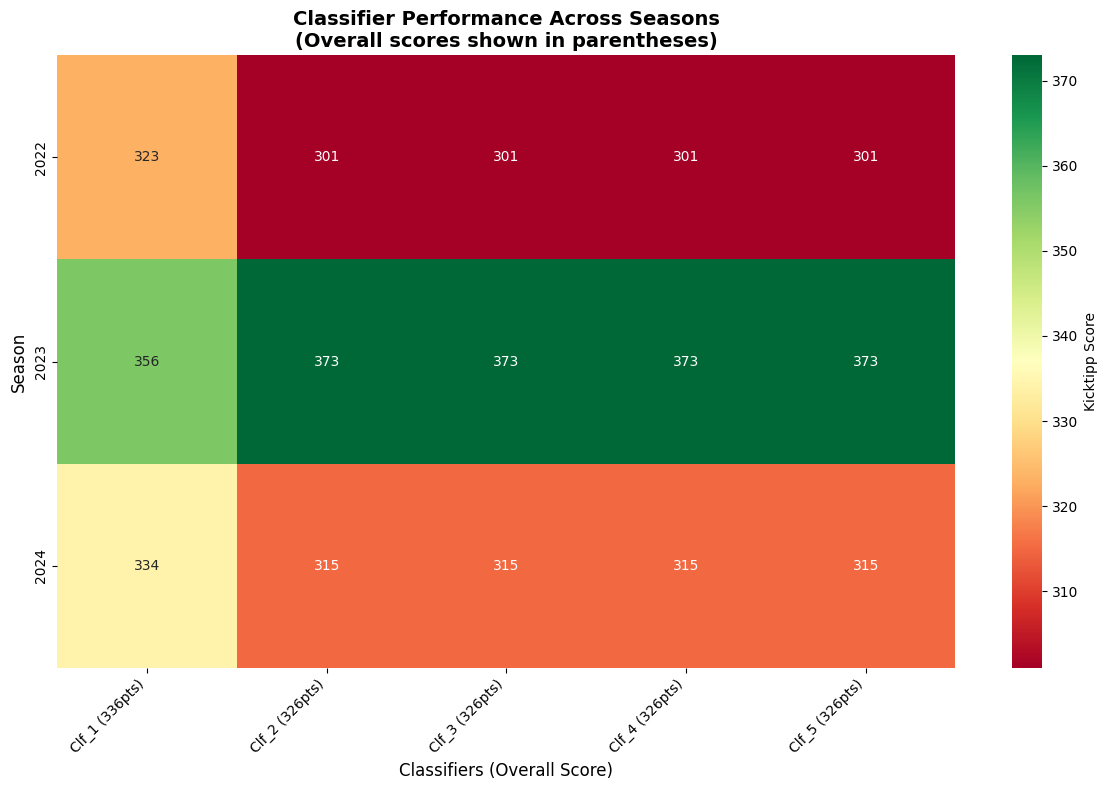


Summary:
Seasons evaluated: 3 ([np.int64(2022), np.int64(2023), np.int64(2024)])
Classifiers compared: 5
Best overall performer: Clf_1 (336pts)
Best seasonal average: Clf_1 (337.7pts avg)


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create heatmap using pre-calculated data
print("Creating Performance Heatmap...")

# Build performance matrix from pre-calculated seasonal_performance
performance_matrix = []
clf_labels = []

# Get overall scores from comparison_df for labels
overall_scores = comparison_df.set_index('Model')['Kicktipp Score'].to_dict()

for i, classifier_file in enumerate(classifier_files, 1):
    overall_score = overall_scores[classifier_file]
    clf_labels.append(f"Clf_{i} ({overall_score}pts)")
    
    # Get seasonal scores for this classifier
    season_scores = [seasonal_performance[season][classifier_file] for season in valid_seasons]
    performance_matrix.append(season_scores)

# Convert to numpy array and transpose for proper orientation
performance_matrix = np.array(performance_matrix).T

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(performance_matrix, 
            annot=True, 
            fmt='d', 
            cmap='RdYlGn',
            xticklabels=clf_labels,
            yticklabels=valid_seasons,
            cbar_kws={'label': 'Kicktipp Score'})

plt.title('Classifier Performance Across Seasons\n(Overall scores shown in parentheses)', fontsize=14, fontweight='bold')
plt.xlabel('Classifiers (Overall Score)', fontsize=12)
plt.ylabel('Season', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary:")
print(f"Seasons evaluated: {len(valid_seasons)} ({valid_seasons})")
print(f"Classifiers compared: {len(classifier_files)}")
print(f"Best overall performer: {clf_labels[np.argmax(list(overall_scores.values()))]}")
print(f"Best seasonal average: Clf_{np.argmax(performance_matrix.mean(axis=0)) + 1} ({performance_matrix.mean(axis=0).max():.1f}pts avg)")


Creating Matchday Performance Line Graph for Season 2024...
Season 2024: 306 matches across 34 matchdays
Matchdays: 1 to 34
Max Reference Total: 318 points (9.4 avg per matchday)
MMB Reference Total: 332 points (9.8 avg per matchday)


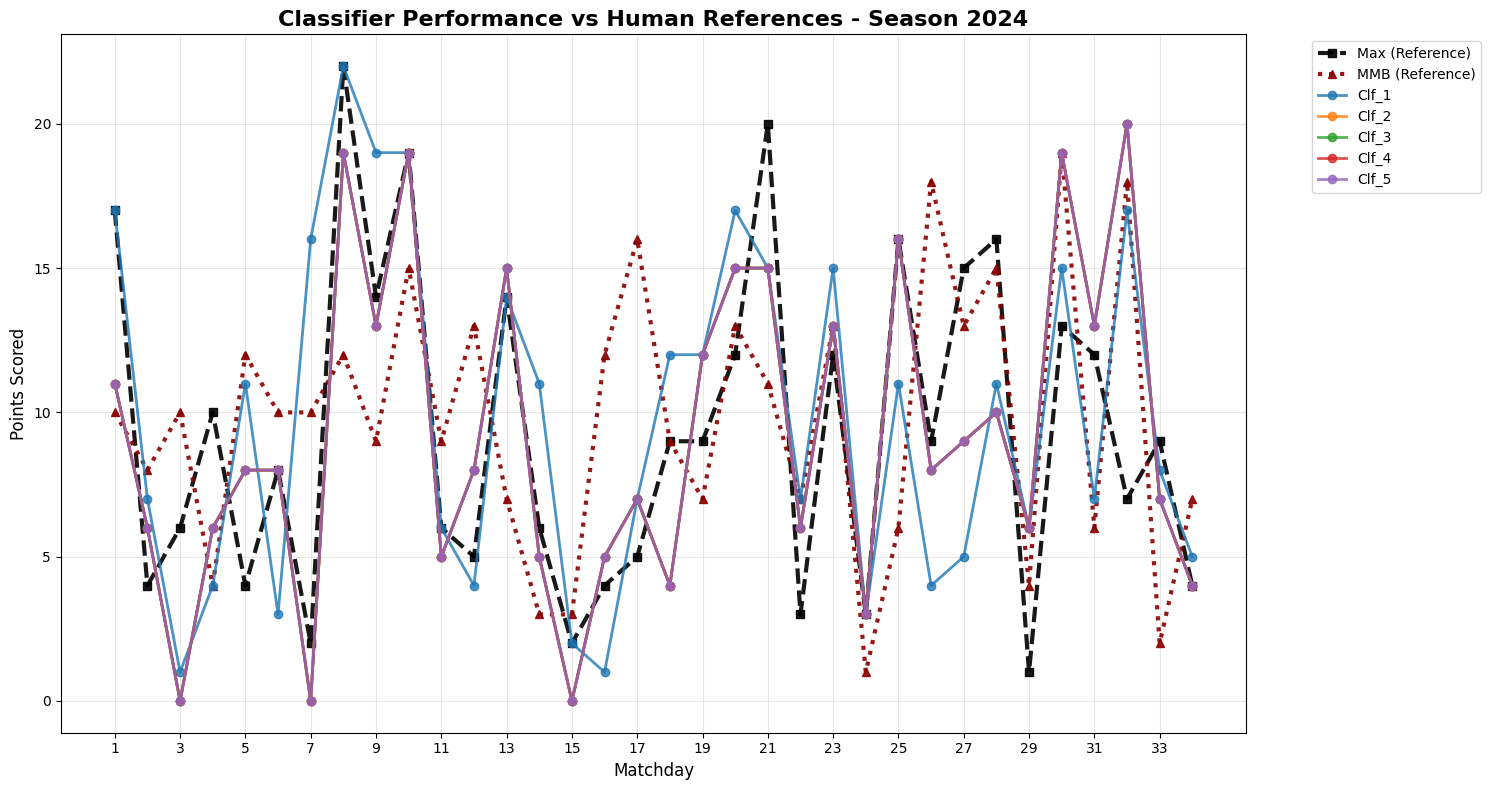


Season 2024 Performance Summary (vs Human References):
----------------------------------------------------------------------
Max (Reference): 318 points | 9.4 avg per matchday
MMB (Reference): 332 points | 9.8 avg per matchday
----------------------------------------------------------------------
Clf_1: 334 points | 9.8 avg | +16 vs Max | +2 vs MMB
Clf_2: 315 points | 9.3 avg | -3 vs Max | -17 vs MMB
Clf_3: 315 points | 9.3 avg | -3 vs Max | -17 vs MMB
Clf_4: 315 points | 9.3 avg | -3 vs Max | -17 vs MMB
Clf_5: 315 points | 9.3 avg | -3 vs Max | -17 vs MMB


In [4]:
# Line graph showing points per matchday for each classifier in season 2024
print("Creating Matchday Performance Line Graph for Season 2024...")

# Reference data from last year (2024 season)
max_reference_data = [17, 4, 6, 10, 4, 8, 2, 22, 14, 19, 6, 5, 14, 6, 2, 4, 5, 9, 9, 12, 20, 3, 12, 3, 16, 9, 15, 16, 1, 13, 12, 7, 9, 4]
mmb_reference_data = [10, 8, 10, 4, 12, 10, 10, 12, 9, 15, 9, 13, 7, 3, 3, 12, 16, 9, 7, 13, 11, 7, 13, 1, 6, 18, 13, 15, 4, 19, 6, 18, 2, 7]
max_total_points = sum(max_reference_data)
mmb_total_points = sum(mmb_reference_data)

# Check if 2024 is in our test data
if 2024 not in X_test['season'].values:
    print("Season 2024 not found in test data!")
    print(f"Available seasons: {sorted(X_test['season'].unique())}")
else:
    # Filter data for season 2024
    season_2024_mask = X_test['season'] == 2024
    season_2024_X = X_test[season_2024_mask]
    season_2024_y_true = y_test[season_2024_mask]
    
    # Get unique matchdays in season 2024
    matchdays = sorted(season_2024_X['matchDay'].unique())
    
    print(f"Season 2024: {len(season_2024_X)} matches across {len(matchdays)} matchdays")
    print(f"Matchdays: {min(matchdays)} to {max(matchdays)}")
    print(f"Max Reference Total: {max_total_points} points ({max_total_points/len(max_reference_data):.1f} avg per matchday)")
    print(f"MMB Reference Total: {mmb_total_points} points ({mmb_total_points/len(mmb_reference_data):.1f} avg per matchday)")
    
    # Calculate points per matchday for each classifier
    plt.figure(figsize=(15, 8))
    
    # Plot reference data first (as baselines)
    reference_matchdays = list(range(1, len(max_reference_data) + 1))
    plt.plot(reference_matchdays, max_reference_data, marker='s', linewidth=3, 
             label='Max (Reference)', color='black', alpha=0.9, linestyle='--')
    plt.plot(reference_matchdays, mmb_reference_data, marker='^', linewidth=3, 
             label='MMB (Reference)', color='darkred', alpha=0.9, linestyle=':')
    
    for i, (classifier_file, classifier) in enumerate(classifiers.items(), 1):
        matchday_points = []
        
        for matchday in matchdays:
            # Filter for specific matchday
            matchday_mask = season_2024_X['matchDay'] == matchday
            matchday_X = season_2024_X[matchday_mask]
            matchday_y_true = season_2024_y_true[matchday_mask]
            
            # Make predictions for this matchday
            matchday_predictions = classifier.predict(matchday_X)
            
            # Calculate points for this matchday (using raw score, not normalized)
            y_true_decoded = [x.split(":") for x in enc.inverse_transform(matchday_y_true)]
            y_pred_decoded = [x.split(":") for x in enc.inverse_transform(matchday_predictions)]
            
            matchday_score = 0
            for true, pred in zip(y_true_decoded, y_pred_decoded):
                if true[0] == pred[0] and true[1] == pred[1]:
                    matchday_score += 5
                elif (int(true[0]) - int(true[1])) == (int(pred[0]) - int(pred[1])):
                    matchday_score += 3
                elif ((true[0] > true[1]) and (pred[0] > pred[1])) or ((true[0] < true[1]) and (pred[0] < pred[1])):
                    matchday_score += 1
            
            matchday_points.append(matchday_score)
        
        # Plot line for this classifier
        plt.plot(matchdays, matchday_points, marker='o', linewidth=2, label=f'Clf_{i}', alpha=0.8)
    
    plt.title('Classifier Performance vs Human References - Season 2024', fontsize=16, fontweight='bold')
    plt.xlabel('Matchday', fontsize=12)
    plt.ylabel('Points Scored', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(matchdays[::2])  # Show every 2nd matchday to avoid crowding
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics with comparison to references
    print(f"\nSeason 2024 Performance Summary (vs Human References):")
    print("-" * 70)
    print(f"Max (Reference): {max_total_points} points | {max_total_points/len(max_reference_data):.1f} avg per matchday")
    print(f"MMB (Reference): {mmb_total_points} points | {mmb_total_points/len(mmb_reference_data):.1f} avg per matchday")
    print("-" * 70)
    
    for i, (classifier_file, classifier) in enumerate(classifiers.items(), 1):
        # Recalculate for summary (reuse logic from above)
        total_points = 0
        for matchday in matchdays:
            matchday_mask = season_2024_X['matchDay'] == matchday
            matchday_X = season_2024_X[matchday_mask]
            matchday_y_true = season_2024_y_true[matchday_mask]
            matchday_predictions = classifier.predict(matchday_X)
            
            y_true_decoded = [x.split(":") for x in enc.inverse_transform(matchday_y_true)]
            y_pred_decoded = [x.split(":") for x in enc.inverse_transform(matchday_predictions)]
            
            for true, pred in zip(y_true_decoded, y_pred_decoded):
                if true[0] == pred[0] and true[1] == pred[1]:
                    total_points += 5
                elif (int(true[0]) - int(true[1])) == (int(pred[0]) - int(pred[1])):
                    total_points += 3
                elif ((true[0] > true[1]) and (pred[0] > pred[1])) or ((true[0] < true[1]) and (pred[0] < pred[1])):
                    total_points += 1
        
        avg_points_per_matchday = total_points / len(matchdays)
        max_difference = total_points - max_total_points
        mmb_difference = total_points - mmb_total_points
        max_diff_sign = "+" if max_difference >= 0 else ""
        mmb_diff_sign = "+" if mmb_difference >= 0 else ""
        
        print(f"Clf_{i}: {total_points} points | {avg_points_per_matchday:.1f} avg | {max_diff_sign}{max_difference} vs Max | {mmb_diff_sign}{mmb_difference} vs MMB")


Creating Cumulative Points Graph for Season 2024...
Season 2024: 306 matches across 34 matchdays


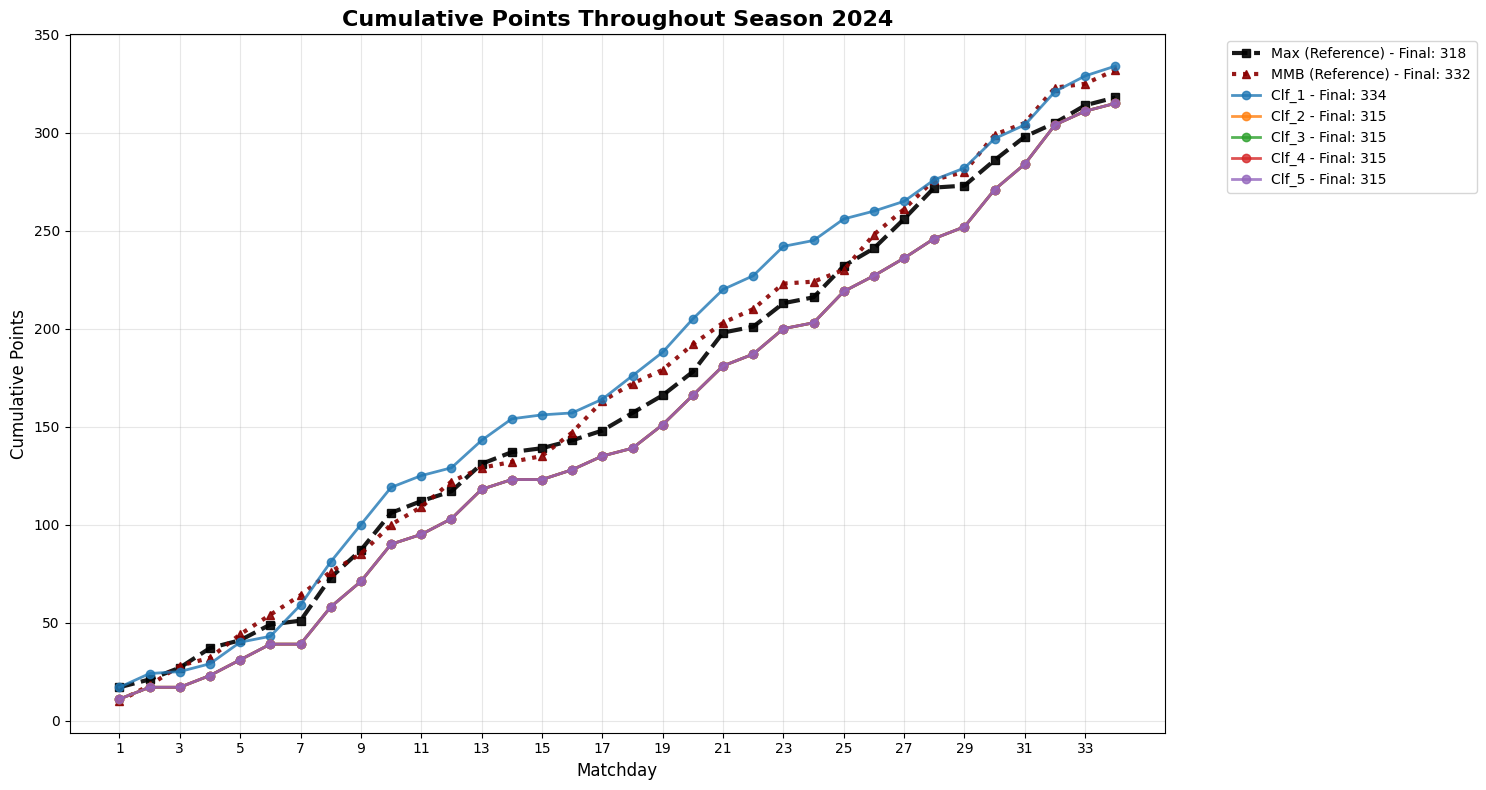


Final Season 2024 Rankings:
1. Clf_1                | 334 points (+16 vs Max, +2 vs MMB)
2. MMB (Reference)      | 332 points ⭐
3. Max (Reference)      | 318 points ⭐
4. Clf_2                | 315 points (-3 vs Max, -17 vs MMB)
5. Clf_3                | 315 points (-3 vs Max, -17 vs MMB)
6. Clf_4                | 315 points (-3 vs Max, -17 vs MMB)
7. Clf_5                | 315 points (-3 vs Max, -17 vs MMB)

🏆 Performance vs Human References:
   Classifiers that beat Max: Clf_1
   Classifiers that beat MMB: Clf_1


In [5]:
# Cumulative points graph showing running total throughout season 2024
print("Creating Cumulative Points Graph for Season 2024...")

# Check if 2024 is in our test data
if 2024 not in X_test['season'].values:
    print("Season 2024 not found in test data!")
    print(f"Available seasons: {sorted(X_test['season'].unique())}")
else:
    # Filter data for season 2024
    season_2024_mask = X_test['season'] == 2024
    season_2024_X = X_test[season_2024_mask]
    season_2024_y_true = y_test[season_2024_mask]
    
    # Get unique matchdays in season 2024
    matchdays = sorted(season_2024_X['matchDay'].unique())
    
    print(f"Season 2024: {len(season_2024_X)} matches across {len(matchdays)} matchdays")
    
    # Calculate cumulative points
    plt.figure(figsize=(15, 8))
    
    # Plot reference cumulative data first
    max_cumulative = np.cumsum(max_reference_data)
    mmb_cumulative = np.cumsum(mmb_reference_data)
    reference_matchdays = list(range(1, len(max_reference_data) + 1))
    plt.plot(reference_matchdays, max_cumulative, marker='s', linewidth=3, 
             label=f'Max (Reference) - Final: {max_total_points}', color='black', alpha=0.9, linestyle='--')
    plt.plot(reference_matchdays, mmb_cumulative, marker='^', linewidth=3, 
             label=f'MMB (Reference) - Final: {mmb_total_points}', color='darkred', alpha=0.9, linestyle=':')
    
    # Store final totals for ranking
    final_totals = []
    
    for i, (classifier_file, classifier) in enumerate(classifiers.items(), 1):
        matchday_points = []
        
        for matchday in matchdays:
            # Filter for specific matchday
            matchday_mask = season_2024_X['matchDay'] == matchday
            matchday_X = season_2024_X[matchday_mask]
            matchday_y_true = season_2024_y_true[matchday_mask]
            
            # Make predictions for this matchday
            matchday_predictions = classifier.predict(matchday_X)
            
            # Calculate points for this matchday (using raw score, not normalized)
            y_true_decoded = [x.split(":") for x in enc.inverse_transform(matchday_y_true)]
            y_pred_decoded = [x.split(":") for x in enc.inverse_transform(matchday_predictions)]
            
            matchday_score = 0
            for true, pred in zip(y_true_decoded, y_pred_decoded):
                if true[0] == pred[0] and true[1] == pred[1]:
                    matchday_score += 5
                elif (int(true[0]) - int(true[1])) == (int(pred[0]) - int(pred[1])):
                    matchday_score += 3
                elif ((true[0] > true[1]) and (pred[0] > pred[1])) or ((true[0] < true[1]) and (pred[0] < pred[1])):
                    matchday_score += 1
            
            matchday_points.append(matchday_score)
        
        # Calculate cumulative points
        cumulative_points = np.cumsum(matchday_points)
        final_total = cumulative_points[-1]
        final_totals.append((f'Clf_{i}', final_total))
        
        # Plot cumulative line for this classifier
        plt.plot(matchdays, cumulative_points, marker='o', linewidth=2, 
                label=f'Clf_{i} - Final: {final_total}', alpha=0.8)
    
    plt.title('Cumulative Points Throughout Season 2024', fontsize=16, fontweight='bold')
    plt.xlabel('Matchday', fontsize=12)
    plt.ylabel('Cumulative Points', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(matchdays[::2])  # Show every 2nd matchday to avoid crowding
    plt.tight_layout()
    plt.show()
    
    # Print final rankings
    print(f"\nFinal Season 2024 Rankings:")
    print("=" * 50)
    
    # Add both references to rankings and sort
    all_results = [('Max (Reference)', max_total_points), ('MMB (Reference)', mmb_total_points)] + final_totals
    all_results.sort(key=lambda x: x[1], reverse=True)
    
    for rank, (name, points) in enumerate(all_results, 1):
        if 'Reference' in name:
            print(f"{rank}. {name:<20} | {points:>3} points ⭐")
        else:
            max_difference = points - max_total_points
            mmb_difference = points - mmb_total_points
            max_diff_sign = "+" if max_difference >= 0 else ""
            mmb_diff_sign = "+" if mmb_difference >= 0 else ""
            print(f"{rank}. {name:<20} | {points:>3} points ({max_diff_sign}{max_difference} vs Max, {mmb_diff_sign}{mmb_difference} vs MMB)")
    
    # Show who beat the human references
    max_winners = [name for name, points in all_results if points > max_total_points and 'Reference' not in name]
    mmb_winners = [name for name, points in all_results if points > mmb_total_points and 'Reference' not in name]
    
    print(f"\n🏆 Performance vs Human References:")
    if max_winners:
        print(f"   Classifiers that beat Max: {', '.join(max_winners)}")
    else:
        print(f"   Max remains unbeaten by all classifiers!")
        
    if mmb_winners:
        print(f"   Classifiers that beat MMB: {', '.join(mmb_winners)}")
    else:
        print(f"   MMB remains unbeaten by all classifiers!")


Creating Matchday Performance Line Graph for Season 2025 (Ongoing)...
Season 2025: 36 matches across 4 matchdays
Matchdays: 1 to 4 (ongoing season)
JenneL Reference (2025): 45 points in 4 matchdays (11.2 avg)


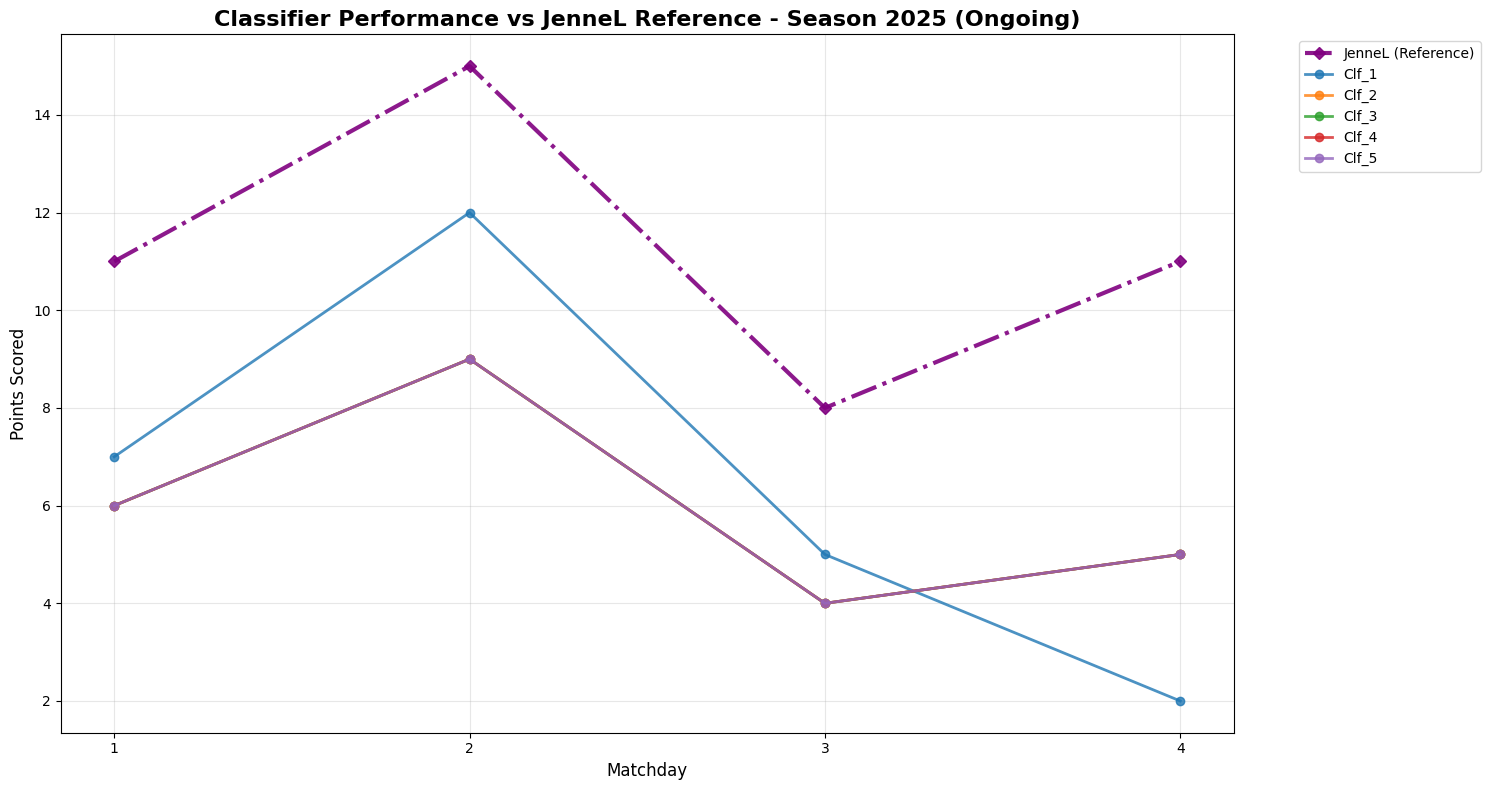


Season 2025 Performance Summary (Ongoing - 4 matchdays):
----------------------------------------------------------------------
JenneL (Reference): 45 points | 11.2 avg per matchday | 4 matchdays
----------------------------------------------------------------------
Clf_1: 26 points | 6.5 avg | -19 vs JenneL (first 4 matchdays)
Clf_2: 24 points | 6.0 avg | -21 vs JenneL (first 4 matchdays)
Clf_3: 24 points | 6.0 avg | -21 vs JenneL (first 4 matchdays)
Clf_4: 24 points | 6.0 avg | -21 vs JenneL (first 4 matchdays)
Clf_5: 24 points | 6.0 avg | -21 vs JenneL (first 4 matchdays)


In [6]:
# Line graph showing points per matchday for each classifier in season 2025 (ongoing)
print("Creating Matchday Performance Line Graph for Season 2025 (Ongoing)...")

# JenneL's reference data for 2025 season (ongoing)
jennel_reference_data_2025 = [11, 15, 8, 11]
jennel_total_points_2025 = sum(jennel_reference_data_2025)

# Check if 2025 is in our test data
if 2025 not in X_test['season'].values:
    print("Season 2025 not found in test data!")
    print(f"Available seasons: {sorted(X_test['season'].unique())}")
else:
    # Filter data for season 2025
    season_2025_mask = X_test['season'] == 2025
    season_2025_X = X_test[season_2025_mask]
    season_2025_y_true = y_test[season_2025_mask]
    
    # Get unique matchdays in season 2025
    matchdays = sorted(season_2025_X['matchDay'].unique())
    
    print(f"Season 2025: {len(season_2025_X)} matches across {len(matchdays)} matchdays")
    print(f"Matchdays: {min(matchdays)} to {max(matchdays)} (ongoing season)")
    print(f"JenneL Reference (2025): {jennel_total_points_2025} points in {len(jennel_reference_data_2025)} matchdays ({jennel_total_points_2025/len(jennel_reference_data_2025):.1f} avg)")
    
    # Calculate points per matchday for each classifier
    plt.figure(figsize=(15, 8))
    
    # Plot JenneL's reference data first (if available matchdays match)
    if len(jennel_reference_data_2025) <= len(matchdays):
        jennel_matchdays = list(range(1, len(jennel_reference_data_2025) + 1))
        plt.plot(jennel_matchdays, jennel_reference_data_2025, marker='D', linewidth=3, 
                 label='JenneL (Reference)', color='purple', alpha=0.9, linestyle='-.')
    
    classifier_2025_data = {}
    
    for i, (classifier_file, classifier) in enumerate(classifiers.items(), 1):
        matchday_points = []
        
        for matchday in matchdays:
            # Filter for specific matchday
            matchday_mask = season_2025_X['matchDay'] == matchday
            matchday_X = season_2025_X[matchday_mask]
            matchday_y_true = season_2025_y_true[matchday_mask]
            
            # Make predictions for this matchday
            matchday_predictions = classifier.predict(matchday_X)
            
            # Calculate points for this matchday (using raw score, not normalized)
            y_true_decoded = [x.split(":") for x in enc.inverse_transform(matchday_y_true)]
            y_pred_decoded = [x.split(":") for x in enc.inverse_transform(matchday_predictions)]
            
            matchday_score = 0
            for true, pred in zip(y_true_decoded, y_pred_decoded):
                if true[0] == pred[0] and true[1] == pred[1]:
                    matchday_score += 5
                elif (int(true[0]) - int(true[1])) == (int(pred[0]) - int(pred[1])):
                    matchday_score += 3
                elif ((true[0] > true[1]) and (pred[0] > pred[1])) or ((true[0] < true[1]) and (pred[0] < pred[1])):
                    matchday_score += 1
            
            matchday_points.append(matchday_score)
        
        # Store data for reuse in cumulative cell
        classifier_2025_data[f'Clf_{i}'] = matchday_points
        
        # Plot line for this classifier
        plt.plot(matchdays, matchday_points, marker='o', linewidth=2, label=f'Clf_{i}', alpha=0.8)
    
    plt.title('Classifier Performance vs JenneL Reference - Season 2025 (Ongoing)', fontsize=16, fontweight='bold')
    plt.xlabel('Matchday', fontsize=12)
    plt.ylabel('Points Scored', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(matchdays[::max(1, len(matchdays)//15)])  # Adaptive tick spacing
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for ongoing season
    print(f"\nSeason 2025 Performance Summary (Ongoing - {len(matchdays)} matchdays):")
    print("-" * 70)
    print(f"JenneL (Reference): {jennel_total_points_2025} points | {jennel_total_points_2025/len(jennel_reference_data_2025):.1f} avg per matchday | {len(jennel_reference_data_2025)} matchdays")
    print("-" * 70)
    
    for i, (classifier_file, classifier) in enumerate(classifiers.items(), 1):
        total_points = sum(classifier_2025_data[f'Clf_{i}'])
        avg_points_per_matchday = total_points / len(matchdays) if len(matchdays) > 0 else 0
        
        # Compare to JenneL (only for matching number of matchdays)
        if len(matchdays) >= len(jennel_reference_data_2025):
            jennel_comparison_points = sum(classifier_2025_data[f'Clf_{i}'][:len(jennel_reference_data_2025)])
            jennel_difference = jennel_comparison_points - jennel_total_points_2025
            jennel_diff_sign = "+" if jennel_difference >= 0 else ""
            print(f"Clf_{i}: {total_points} points | {avg_points_per_matchday:.1f} avg | {jennel_diff_sign}{jennel_difference} vs JenneL (first {len(jennel_reference_data_2025)} matchdays)")
        else:
            print(f"Clf_{i}: {total_points} points | {avg_points_per_matchday:.1f} avg per matchday | {len(matchdays)} matchdays played")
    
    # Store data for next cell
    season_2025_matchdays = matchdays
    season_2025_classifier_data = classifier_2025_data


Creating Cumulative Points Graph for Season 2025 (Ongoing)...
Season 2025: 4 matchdays completed so far


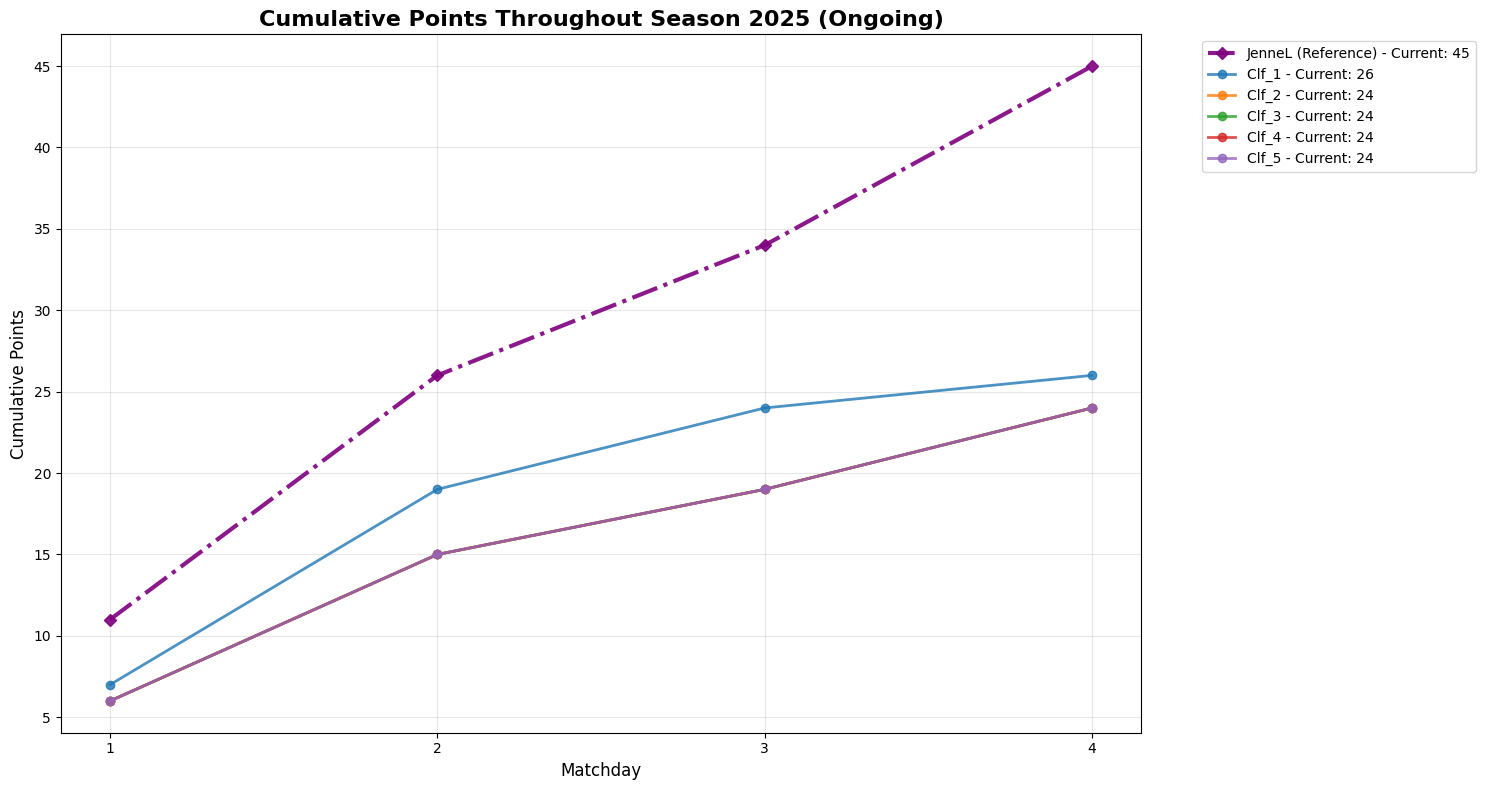


Current Season 2025 Rankings (After 4 matchdays):
1. JenneL (Reference)   |  45 points | 11.2 avg per matchday ⭐
2. Clf_1                |  26 points | 6.5 avg | -19 vs JenneL
3. Clf_2                |  24 points | 6.0 avg | -21 vs JenneL
4. Clf_3                |  24 points | 6.0 avg | -21 vs JenneL
5. Clf_4                |  24 points | 6.0 avg | -21 vs JenneL
6. Clf_5                |  24 points | 6.0 avg | -21 vs JenneL

Projected Final Totals (assuming 34 matchday season):
--------------------------------------------------
1. JenneL (Reference)   | 382 projected points ⭐
2. Clf_1                | 221 projected points
3. Clf_2                | 204 projected points
4. Clf_3                | 204 projected points
5. Clf_4                | 204 projected points
6. Clf_5                | 204 projected points

📊 Current Season Insights:
   🏆 Leading: JenneL (Reference) with 45 points
   📉 Trailing: Clf_5 with 24 points
   📈 Gap: 21 points

🏆 Performance vs JenneL Reference:
   JenneL rem

In [7]:
# Cumulative points graph showing running total throughout season 2025 (ongoing)
print("Creating Cumulative Points Graph for Season 2025 (Ongoing)...")

# Check if we have 2025 data from previous cell
if 'season_2025_classifier_data' in locals() and season_2025_classifier_data:
    print(f"Season 2025: {len(season_2025_matchdays)} matchdays completed so far")
    
    # Calculate cumulative points
    plt.figure(figsize=(15, 8))
    
    # Plot JenneL's cumulative reference data first (if available matchdays match)
    if len(jennel_reference_data_2025) <= len(season_2025_matchdays):
        jennel_cumulative_2025 = np.cumsum(jennel_reference_data_2025)
        jennel_matchdays_2025 = list(range(1, len(jennel_reference_data_2025) + 1))
        plt.plot(jennel_matchdays_2025, jennel_cumulative_2025, marker='D', linewidth=3, 
                 label=f'JenneL (Reference) - Current: {jennel_total_points_2025}', 
                 color='purple', alpha=0.9, linestyle='-.')
    
    # Store final totals for ranking
    final_totals_2025 = []
    
    for i, (clf_name, matchday_points) in enumerate(season_2025_classifier_data.items(), 1):
        # Calculate cumulative points
        cumulative_points = np.cumsum(matchday_points)
        final_total = cumulative_points[-1] if len(cumulative_points) > 0 else 0
        final_totals_2025.append((clf_name, final_total))
        
        # Plot cumulative line for this classifier
        plt.plot(season_2025_matchdays, cumulative_points, marker='o', linewidth=2, 
                label=f'{clf_name} - Current: {final_total}', alpha=0.8)
    
    plt.title('Cumulative Points Throughout Season 2025 (Ongoing)', fontsize=16, fontweight='bold')
    plt.xlabel('Matchday', fontsize=12)
    plt.ylabel('Cumulative Points', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(season_2025_matchdays[::max(1, len(season_2025_matchdays)//15)])  # Adaptive tick spacing
    plt.tight_layout()
    plt.show()
    
    # Print current rankings for 2025
    print(f"\nCurrent Season 2025 Rankings (After {len(season_2025_matchdays)} matchdays):")
    print("=" * 60)
    
    # Add JenneL to rankings and sort
    all_results_2025 = [('JenneL (Reference)', jennel_total_points_2025)] + final_totals_2025
    all_results_2025.sort(key=lambda x: x[1], reverse=True)
    
    for rank, (name, points) in enumerate(all_results_2025, 1):
        avg_per_matchday = points / len(season_2025_matchdays) if len(season_2025_matchdays) > 0 else 0
        if 'Reference' in name:
            print(f"{rank}. {name:<20} | {points:>3} points | {avg_per_matchday:.1f} avg per matchday ⭐")
        else:
            jennel_difference = points - jennel_total_points_2025
            jennel_diff_sign = "+" if jennel_difference >= 0 else ""
            print(f"{rank}. {name:<20} | {points:>3} points | {avg_per_matchday:.1f} avg | {jennel_diff_sign}{jennel_difference} vs JenneL")
    
    # Projected final totals (assuming 34 matchdays total)
    if len(season_2025_matchdays) > 0 and len(season_2025_matchdays) < 34:
        print(f"\nProjected Final Totals (assuming 34 matchday season):")
        print("-" * 50)
        
        projected_totals = []
        # Add JenneL projection
        jennel_current_avg = jennel_total_points_2025 / len(jennel_reference_data_2025)
        jennel_projected = round(jennel_current_avg * 34)
        projected_totals.append(('JenneL (Reference)', jennel_projected))
        
        # Add classifier projections
        for name, current_points in final_totals_2025:
            current_avg = current_points / len(season_2025_matchdays)
            projected_total = round(current_avg * 34)
            projected_totals.append((name, projected_total))
        
        projected_totals.sort(key=lambda x: x[1], reverse=True)
        
        for rank, (name, projected_points) in enumerate(projected_totals, 1):
            if 'Reference' in name:
                print(f"{rank}. {name:<20} | {projected_points:>3} projected points ⭐")
            else:
                print(f"{rank}. {name:<20} | {projected_points:>3} projected points")
    
    # Performance insights
    if len(season_2025_matchdays) > 0:
        best_performer = all_results_2025[0]
        worst_performer = all_results_2025[-1]
        
        print(f"\n📊 Current Season Insights:")
        print(f"   🏆 Leading: {best_performer[0]} with {best_performer[1]} points")
        print(f"   📉 Trailing: {worst_performer[0]} with {worst_performer[1]} points")
        print(f"   📈 Gap: {best_performer[1] - worst_performer[1]} points")
        
        # Show who beat JenneL
        jennel_winners = [name for name, points in all_results_2025 if points > jennel_total_points_2025 and 'Reference' not in name]
        
        print(f"\n🏆 Performance vs JenneL Reference:")
        if jennel_winners:
            print(f"   Classifiers that beat JenneL: {', '.join(jennel_winners)}")
        else:
            print(f"   JenneL remains unbeaten by all classifiers!")
        
        # Compare to 2024 pace
        if 'max_total_points' in locals():
            max_2024_pace = max_total_points / 34  # Assuming 34 matchdays in 2024
            jennel_2025_pace = jennel_total_points_2025 / len(jennel_reference_data_2025)
            
            # Find best classifier pace
            best_classifier = [item for item in all_results_2025 if 'Reference' not in item[0]]
            if best_classifier:
                current_leader_pace = best_classifier[0][1] / len(season_2025_matchdays)
                
                print(f"\n📈 Pace Comparisons:")
                print(f"   JenneL 2025 pace: {jennel_2025_pace:.1f} points per matchday")
                print(f"   Max 2024 pace: {max_2024_pace:.1f} points per matchday")
                print(f"   Best classifier pace: {current_leader_pace:.1f} points per matchday")
                
                if jennel_2025_pace > max_2024_pace:
                    print(f"   🚀 JenneL's 2025 pace is ahead of Max's 2024 pace!")
                else:
                    print(f"   📊 JenneL's 2025 pace is behind Max's 2024 pace")

else:
    print("No 2025 season data available. Run the previous cell first.")
